In [12]:
pip install tensorflow_datasets

Note: you may need to restart the kernel to use updated packages.


In [13]:
!pip install tensorflow==2.13

In [28]:
import tensorflow_datasets as tfds

#Load full train dataset
full_ds, ds_info = tfds.load('plant_village', split='train', as_supervised=True, with_info=True)

In [29]:
ds_info

tfds.core.DatasetInfo(
    name='plant_village',
    full_name='plant_village/1.0.2',
    description="""
    The PlantVillage dataset consists of 54303 healthy and unhealthy leaf images
    divided into 38 categories by species and disease.
    
    NOTE: The original dataset is not available from the original source
    (plantvillage.org), therefore we get the unaugmented dataset from a paper that
    used that dataset and republished it. Moreover, we dropped images with
    Background_without_leaves label, because these were not present in the original
    dataset.
    
    Original paper URL: https://arxiv.org/abs/1511.08060 Dataset URL:
    https://data.mendeley.com/datasets/tywbtsjrjv/1
    """,
    homepage='https://arxiv.org/abs/1511.08060',
    data_dir='/home/draoi/tensorflow_datasets/plant_village/1.0.2',
    file_format=tfrecord,
    download_size=827.82 MiB,
    dataset_size=815.37 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),

In [30]:
class_names = ds_info.features['label'].names

In [31]:
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry___healthy',
 'Cherry___Powdery_mildew',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___Common_rust',
 'Corn___healthy',
 'Corn___Northern_Leaf_Blight',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___healthy',
 'Potato___Late_blight',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___healthy',
 'Strawberry___Leaf_scorch',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___healthy',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomat

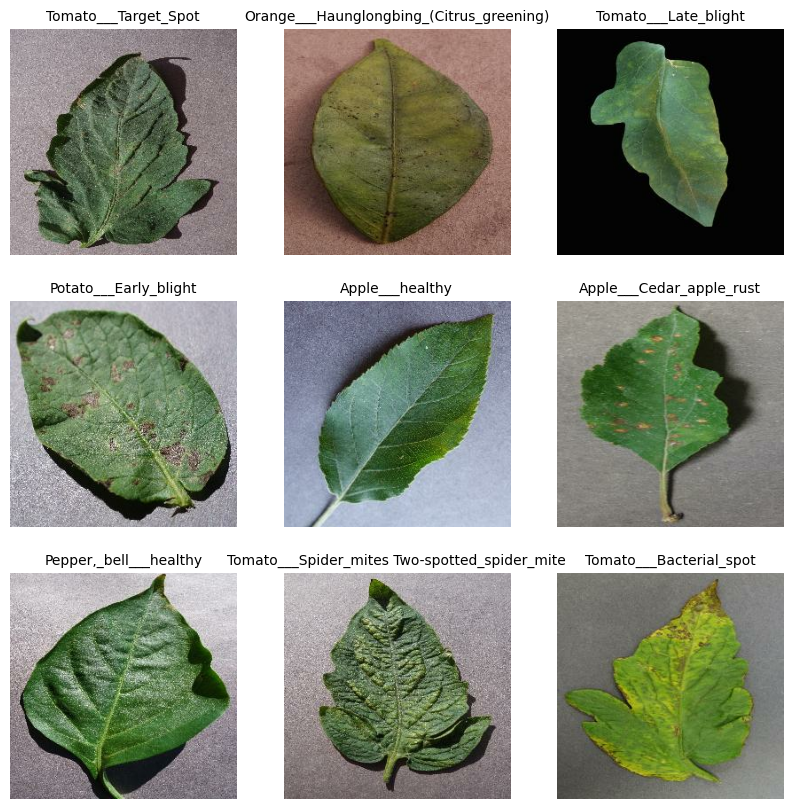

In [32]:
import matplotlib.pyplot as plt

def show_examples(dataset, n_images=9, title_fontsize=10):
    """Displays a grid of images with smaller titles."""
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(n_images)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(ds_info.features['label'].int2str(label), fontsize=title_fontsize)
        plt.axis("off")

show_examples(full_ds)

In [33]:
import tensorflow as tf
import datetime

#Setting up TensorBoard callback directory
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [34]:
#Xception expects 299x299 images
IMG_SIZE = 299  

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1  # Normalize the images to [-1, 1]
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

full_ds = full_ds.map(format_example)

#Data augmenting
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
])

In [35]:
base_model = tf.keras.applications.Xception(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                            include_top=False,
                                            weights='imagenet')

#Freeze convolutional base
base_model.trainable = False  

#Custom head for our dataset
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(ds_info.features['label'].num_classes, activation='softmax')
])

In [36]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train model

In [37]:

#Splitting dataset
train_size = int(0.8 * ds_info.splits['train'].num_examples)
train_ds = full_ds.take(train_size)
val_ds = full_ds.skip(train_size)

#Batching and prefetching for performance
BATCH_SIZE = 32
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

#TnsorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#Train model
history = model.fit(train_ds,
                    epochs=3,
                    validation_data=val_ds,
                    callbacks=[tensorboard_callback])

Epoch 1/3
1358/1358 [==============================] - 112s 81ms/step - loss: 0.6483 - accuracy: 0.8474 - val_loss: 0.3133 - val_accuracy: 0.9146
Epoch 2/3
1358/1358 [==============================] - 111s 82ms/step - loss: 0.2574 - accuracy: 0.9298 - val_loss: 0.2233 - val_accuracy: 0.9360
Epoch 3/3
1358/1358 [==============================] - 110s 81ms/step - loss: 0.1936 - accuracy: 0.9462 - val_loss: 0.1836 - val_accuracy: 0.9470


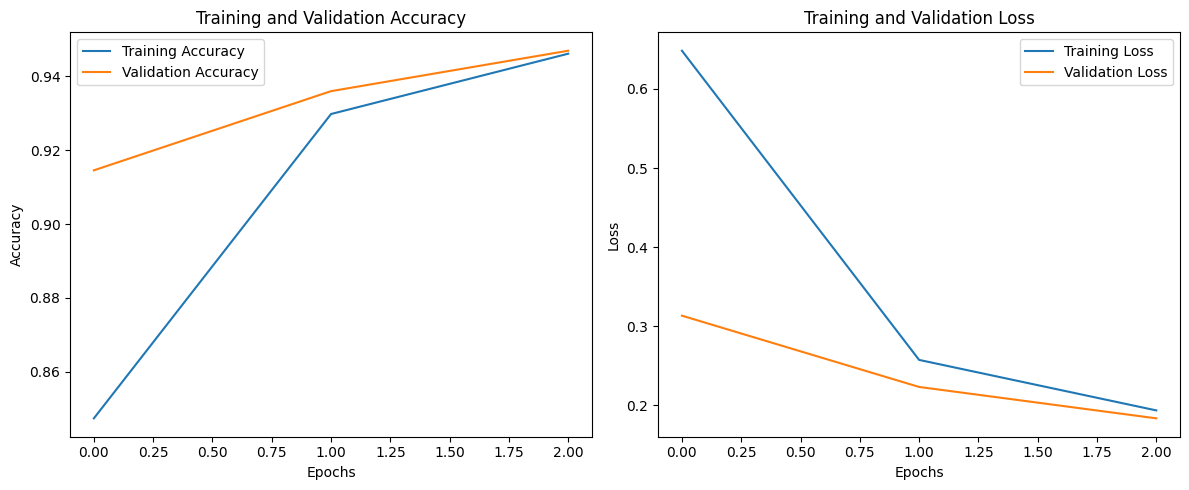

In [41]:
plt.figure(figsize=(12, 5)) 
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(3)

#Plotting Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout() 
plt.show()

In [42]:
import numpy as np 

#Make predictions
val_predictions = model.predict(val_ds)
#Convert predictions from probabilities to class labels
val_pred_labels = np.argmax(val_predictions, axis=-1)
#Collect true labels from validation dataset
true_labels = np.concatenate([y.numpy() for x, y in val_ds.unbatch().batch(1)])
#Calculate confusion matrix
conf_matrix = tf.math.confusion_matrix(true_labels, val_pred_labels)
conf_matrix = conf_matrix.numpy()

340/340 [==============================] - 27s 58ms/step


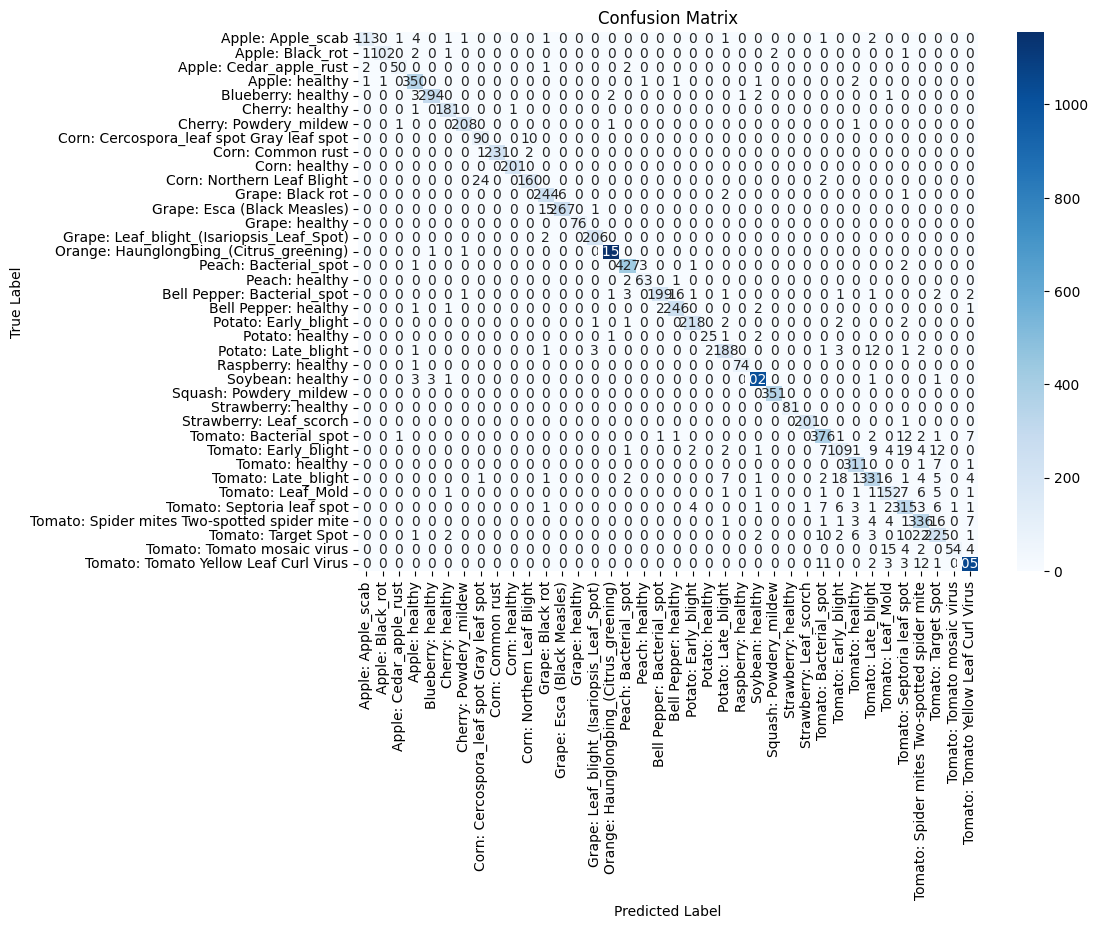

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

#Class names that correspond to each index
class_names = ['Apple: Apple_scab',
 'Apple: Black_rot',
 'Apple: Cedar_apple_rust',
 'Apple: healthy',
 'Blueberry: healthy',
 'Cherry: healthy',
 'Cherry: Powdery_mildew',
 'Corn: Cercospora_leaf spot Gray leaf spot',
 'Corn: Common rust',
 'Corn: healthy',
 'Corn: Northern Leaf Blight',
 'Grape: Black rot',
 'Grape: Esca (Black Measles)',
 'Grape: healthy',
 'Grape: Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Orange: Haunglongbing_(Citrus_greening)',
 'Peach: Bacterial_spot',
 'Peach: healthy',
 'Bell Pepper: Bacterial_spot',
 'Bell Pepper: healthy',
 'Potato: Early_blight',
 'Potato: healthy',
 'Potato: Late_blight',
 'Raspberry: healthy',
 'Soybean: healthy',
 'Squash: Powdery_mildew',
 'Strawberry: healthy',
 'Strawberry: Leaf_scorch',
 'Tomato: Bacterial_spot',
 'Tomato: Early_blight',
 'Tomato: healthy',
 'Tomato: Late_blight',
 'Tomato: Leaf_Mold',
 'Tomato: Septoria leaf spot',
 'Tomato: Spider mites Two-spotted spider mite',
 'Tomato: Target Spot',
 'Tomato: Tomato mosaic virus',
 'Tomato: Tomato Yellow Leaf Curl Virus']

#Heatmap for confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [15]:
import os
#Nessessary dir structure to package a custom model
save_model_path = os.path.join('plant_village_model', '000000001')
model.save(save_model_path, save_format='tf')

In [16]:
import tarfile
import os

def make_tarfile(output_filename, source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))

#Create a tarfile of the saved model directory
make_tarfile('plant_village_model.tar.gz', 'plant_village_model')

In [17]:
import boto3

def upload_to_s3(file_name, bucket, object_name=None):
    """ Upload a file to an S3 bucket

    :param file_name: File to upload
    :param bucket: Bucket to upload to
    :param object_name: S3 object name. If not specified then file_name is used
    :return: True if file was uploaded, else False
    """
    #If S3 object_name not specified use file_name
    if object_name is None:
        object_name = file_name

    #Upload file
    s3_client = boto3.client('s3')
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except Exception as e:
        print(f"Error uploading file to S3: {e}")
        return False
    return True

#Bucket name and path in  bucket
bucket_name = 'awsprojectbucket123321'
s3_key = 'new_model/plant_village_model.tar.gz'

#Upload file to S3
upload_to_s3('plant_village_model.tar.gz', bucket_name, s3_key)

True

In [ ]:
import os
import boto3

def upload_directory(path, bucket, destination):
    s3 = boto3.client('s3')
    for root, dirs, files in os.walk(path):
        for file in files:
            #Create full path of the file
            full_path = os.path.join(root, file)
            #Create full S3 path
            s3_path = os.path.join(destination, os.path.relpath(full_path, start=path))
            print(f"Uploading {full_path} to s3://{bucket}/{s3_path}")
            #Upload  file
            s3.upload_file(full_path, bucket, s3_path)

upload_directory('plant_village_model', 'awsprojectbucket123321', 'plant_village_model')

In [18]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [19]:
import sagemaker
from sagemaker.model import Model
from sagemaker.tensorflow import TensorFlowModel

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [20]:
sagemaker_session = sagemaker.Session()

In [21]:
model_data = 's3://awsprojectbucket123321/new_model/plant_village_model.tar.gz'

In [22]:
tf_model = TensorFlowModel(model_data=model_data,
                        #role='AmazonSageMaker-ExecutionRole-20240421T211742',
                        role=sagemaker.get_execution_role(),
                        framework_version='2.13',
                        sagemaker_session=sagemaker_session)

In [23]:
predictor = tf_model.deploy(initial_instance_count=1,
                         instance_type='ml.t2.xlarge')
#ml.t2.xlarge
# ml.t2.medium

------!

In [ ]:
import boto3
import json

runtime = boto3.client('sagemaker-runtime')

#test sending a JSON payload
response = runtime.invoke_endpoint(EndpointName='your-endpoint-name',
                                   ContentType='application/json',
                                   Body=json.dumps(your_image_data))
print(response['Body'].read())

# Testing Endpoint

In [41]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input

def load_and_preprocess_image(img_path):
    #Load image with target size for Xception
    img = image.load_img(img_path, target_size=(299, 299))
    img_array = image.img_to_array(img) #Convert image to numpy array
    img_array = np.expand_dims(img_array, axis=0)  #Add batch dimension
    img_array = preprocess_input(img_array)  #Preprocess image
    return img_array

image_path = 'Untitled.jpg'
image_data = load_and_preprocess_image(image_path)


In [46]:
import json
#Converting image data for API call
payload = json.dumps({"instances": image_data.tolist()})

In [47]:
import boto3

def invoke_endpoint(endpoint_name, payload):
    runtime = boto3.client('runtime.sagemaker')
    response = runtime.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType='application/json',
        Body=payload
    )
    result = response['Body'].read()
    return json.loads(result)

# Example usage
endpoint_name = 'tensorflow-inference-2024-04-30-10-36-17-777'
response = invoke_endpoint(endpoint_name, payload)
print('Inference results:', response)

Inference results: {'predictions': [[0.000202017196, 4.21924278e-06, 2.08111416e-07, 1.68168594e-06, 2.35413859e-06, 8.67889526e-07, 2.44553917e-06, 0.000105755149, 3.30154398e-05, 0.000390357454, 0.00111757673, 7.83708856e-07, 6.45753815e-08, 7.75698172e-09, 3.97020386e-07, 0.00667952839, 0.0166805964, 1.10081949e-07, 6.00086387e-05, 8.55952731e-09, 2.01377517e-07, 4.68078731e-09, 0.00901329704, 4.46956e-08, 1.52118218e-07, 2.75622909e-07, 5.71224028e-08, 0.0100875478, 0.000149322834, 0.727727532, 3.89590689e-08, 0.138052806, 0.000103060018, 0.000778565765, 4.00594536e-06, 1.62696779e-07, 1.96243514e-06, 0.0887988284]]}


In [48]:
predictions = response['predictions'][0]

#Index of the max probability
predicted_index = np.argmax(predictions)

predicted_class_name = class_names[predicted_index]
max_probability = predictions[predicted_index]

print(f"Predicted Class: {predicted_class_name}, Probability: {max_probability:.4f}")

Predicted Class: Tomato: Early_blight, Probability: 0.7277
